Pitch detection methods
==================================

After a description of some theoretical methods to pitch detection - first in the time domain, then in the frequency domain - algorithms used in industry such as the Yin algorithm are covered.

Sources: 
- [Ba, He, et al. "BaNa: A hybrid approach for noise resilient pitch detection." 2012 IEEE Statistical Signal Processing Workshop (SSP). IEEE, 2012.](https://www.researchgate.net/profile/Na_Yang7/publication/268035217_BaNa_A_Hybrid_Approach_for_Noise_Resilient_Pitch_Detection/links/545fb4b60cf2c1a63bfdb9ec.pdf)

- [Gerhard, David. Pitch extraction and fundamental frequency: History and current techniques. Regina: Department of Computer Science, University of Regina, 2003.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.834&rep=rep1&type=pdf)

- [Philip McLeod's: Fast, Accurate Pitch Detection Tools for Music Analysis (doctoral thesis)](http://miracle.otago.ac.nz/tartini/papers/Philip_McLeod_PhD.pdf)

- [Stanford MIR](https://github.com/stevetjoa/stanford-mir/) author: Steve Tjoa

- [Librosa](http://musicinformationretrieval.com/) author: Brian McFee

- [Pyo](http://ajaxsoundstudio.com/pyodoc/api/classes/analysis.html) has the Yin algorithm. author: ?

- [Python code](https://gist.github.com/endolith/255291) for some of the simpler pitch-detection algorithms described below, such as zero-crossing, FFT peak, or autocorrelation.

- Here is a [C++ library with a python wrapper: aubio](https://github.com/aubio/aubio)



Time domain
-----------



Zero-Crossing
---------------------
Count zero-crossings in a given number of samples and compute frequency from this. 

** Pros: **
- used for basic guitar tuners

** Cons: **
- inaccurate when overtones or noise cause multiple zero-crossings per period

Autocorrelation 
-----------------------------
Calculate pitch for a window of audio of length W.

**(ACF) type I**
Idea: look at every possible lag $ \theta $

$$ \sum_{n = 0}^{\frac{W}{2} - 1} x_n * x_{n+\theta}, 0 \leq \theta \leq \frac{W}{2} $$

**(ACF) type II**
Sum n = 0 : (W – Theta – 1) x_n * x_{n+Theta}, Theta in 0:W
Decreases as value of Theta increases
To get same result as Type 1, pad with zeroes to double window size and keep Theta in 0:W/2
Works better for non-stationary signals, as effective center t’c is stationary?

**Autocorrelation via FFT**
Zero-pad signal window with number of output terms desired, usually p = W/2
Compute FFT
Calculate squared magnitude of each complex term (power spectral density)
IFFT yields autocorrelation

** Pros **
- Works well for stationary signals (same pattern is repeated)
- Resistant to noise
- Good for lower pitches and small frequency ranges: used often for speech analysis

** Cons **
- Risk of octave inaccuracy, since there can be higher peaks than the fundamental
- Requires multiple periods to be accurate (FFT frame length), so some averaging is unavoidable
- Works mainly for harmonic signals
- Resolution is dependent on sampling rate

Squared difference function (SDF)
----------------------------------
Much like autocorrelation: idea: adjacent periods have similar shapes
Subtract shifted window from original and find global minimum

d’(Theta) = sum i in 0 : (W/2-1) [x_i – x_{i+Theta}]^2, Theta in 0:W/2

Need only a small number of periods per window, unlike autocorrelation. SDF is the safer option, because unless the 
window happens to contain a whole number of signal periods, partial waveforms will contribute different amounts 
depending on phase. 
No need to window the signal

Frequency domain
----------------

Phase Vocoder (Keiler and Marchand)
------------------------------------

- Find local maxima in spectrum
- Expected phase advance over the given hop size is known for a given frequency bin
- Measured phase difference from this expected offset is used to calculate frequency of the partial 
Signal Derivatives 
- Marchand: Derivative of a sine wave is another sine wave of the same frequency, but with different phase and amplitude




Harmonic product spectrum (HPS)
-------------------------------

1. STFT of signal
2. Downsample by a factor i for i in 2:n. Each time, the ith harmonic will align with the fundamental. 
3. Multiply the resulting spectra together and retrieve the max peak

This method only works with a large enough FFT window, leading to lower time resolution.



**Subharmonic-to-harmonic ratio (Sun) **

Choose correct octave: given F0 or its subharmonic
Ratio of sum of harmonic amplitude SH = Sum for i in 1:n X(iF0)
Snd sum of subharmonic amplitude SS = X((i-1/2)F0)
Gives subharmonic to harmonic ratio SHR = SS/SH
Choose F0 or F0/2 as fundamental depending whether SHR goes over threshold
Commonly used in speech
Algorithm is modified to use logarithmic frequency axis

Cepstrum and Mel-Frequency Cepstral Coefficients
------------------------------------------------

**Cepstral analysis**

Bogart, Healy, Tukey -> Noll

Can be defined as the **power spectrum of the log of the power spectrum of a signal**

Algorithm is a mathematical trick based on the following assumption: the signal $S(n)$ made of fast-varying components, goes through a filter or impulse response (e.g. vocal tract), $ H(n) $, which governs the overall shape of the spectrogram with its slow varying components. We want to create a linear filter that separates the slow and fast varying components from each other.

1. Take spectrum (Modulus of FFT) of windowed signal. $ X(n) = S(n)H(n) $ and $ ||X(n)|| = ||S(n)|| ||H(n)|| $
2. Take Log on both sides: $ log||X(n)|| = log||S(n)|| + log||H(n)|| $
3. Take IFFT on both sides: $ x(n) = s(n) + h(n) $
4. Choose cutoff value manually
5. For pitch detection, choose max peak above cutoff
 


In [1]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
#import essentia, essentia.standard as ess
plt.rcParams['figure.figsize'] = (14,4)

In [4]:
url = 'http://audio.musicinformationretrieval.com/simple_loop.wav'
urllib.urlretrieve(url, filename='simple_loop.wav')

('simple_loop.wav', <httplib.HTTPMessage instance at 0x10f888560>)

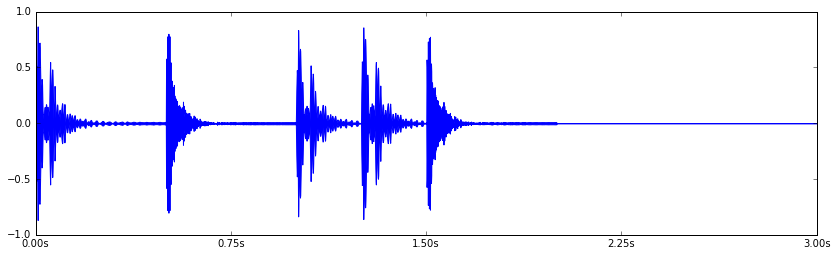

In [6]:
x, fs = librosa.load('simple_loop.wav')
librosa.display.waveplot(x, sr=fs)

In [7]:
IPython.display.Audio(x, rate=fs)

In [8]:
mfccs = librosa.feature.mfcc(x, sr=fs)
print mfccs.shape

(20, 130)


In this case, mfcc computed 20 MFCCs over 130 frames.
The very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. It only conveys a constant offset, i.e. adding a constant value to the entire spectrum. Therefore, many practitioners will discard the first MFCC when performing classification. For now, we will use the MFCCs as is.
Display the MFCCs:

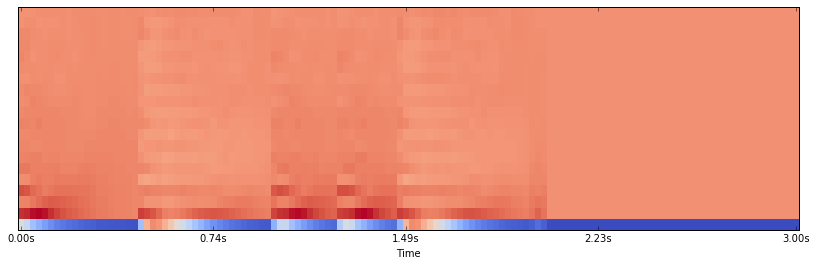

In [9]:
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

Yin algorithm
-------------

Cheveigne, Kawahara

The main article is [here](http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf)
The algorithm combines some of the theoretical algorithms such as autocorrelation, to get the best out of each. It is possible to restrict the range of the pitch if additional information about it is available. 

**The steps and error rates after each**

1. Autocorrelation (10.0)

2. Difference function (1.95)

3. Cumulative mean normalized difference function (weights the value of each lag to distinguish F0 from F1) (1.69)

4. Absolute threshold (avoid octave error, if one of the higher order dips is deeper than the one at F0. Choose the lowest possible pitch with a dip below a certain threshold. If no dip is below, choose the global minimum) (.78)

5. Parabolic interpolation (increase precision) (.77)

6. Best local estimate (.50)


Stanford MIR has an algorithm, but ess. is deprecated (essentia)

In [ ]:
yin = ess.PitchYinFFT()
spectrum = ess.Spectrum()

def get_pitch(segment):
    if len(segment) < 4096: # hack to get around Essentia error
        N = len(segment) if len(segment) % 2 == 0 else len(segment) - 1
    else:
        N = 4096
    pitch, pitch_conf = yin(spectrum(segment[:N]))
    return pitch

Bana algorithm
----------------
- Noise resilient Pitch detection for speech
- State-of-the-art pitch detection algorithms are YIN, Praat, Cepstrum and Harmonic Product Spectrum
- None are resilient to noise. Bana is a hybrid that "even for the very noisy scenario of 0dB" can "correctly detect about 80% of the pitch values, outperforming the most competitive state-of-the-art reference algorithm YIN by 12%."

**Algorithm outline** (Pseudocode and code are available)
- Preprocess data using a bandpass filter so that only pitches relevant to the frequency range of speech are considered (50 Hz to 3000 Hz to capture some harmonics)
- Search for harmonic peaks: keep the five "higher than a certain threshold and with the lowest frequencies to derive pitch candidates"
- Calculate C(5,2) ratios between the peaks. If the ratios fall within a tolerated range for a given set of two harmonics (e.g. F4 and F2), include a new candidate to the set of candidates
- Add the lowest frequency peak and the Cepstrum estimate to the set of candidates
- Assign each candidate a confidence score (1 at first)
- If two candidates are within 10 Hz of each other, turn them into one and add 1 to the confidence score
- Viterbi algorithm
- $PathCost({p_n}) = \sum_{n=1}^{N_{frame}-1} Cost(F_i^n, F_j^{n+1})  $
- $Cost(F_i^n, F_j^{n+1}) = \left| log_2 \frac{F_i^n}{F_j^{n+1}} \right| + w \frac{1}{V_i^n}$
- When viterbi meets an unvoiced part (number of candidates is zero) it resets path cost to zero and starts over for the following frames
- When evaluating the accuracy, pitch values that differ by more than 10% from the ground truth values are counted as errors.

Other algorithms to explore
----------------------------
Wavelet? Linear Predictive Coding (LPC)?